**MileStone4: Basline Pricing Engine**

Goal: Build a simple rule-based baseline pricing engine using demand_ratio = Number_of_Riders / Number_of_Drivers with threshold = 0.5. Visualize baseline vs actual price and write markdown explaining results.

To design a baseline pricing engine that simulates how ride prices can be dynamically adjusted based on demand (time or inventory factors). This baseline model will help evaluate revenue lift, profit margin, and conversion rate improvements compared to static pricing strategies.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
# Load cleaned dataset
df = pd.read_csv("cleaned_csv_dataset.csv")

# ✅ Step 1: Ensure price-related column exists
if "Historical_Cost_of_Ride" not in df.columns:
    raise KeyError("❌ Column 'Historical_Cost_of_Ride' not found in dataset.")

# ✅ Step 2: Define baseline threshold
threshold = 0.5  # midpoint ratio for adjustment

# ✅ Step 3: Compute base price (mean of ride costs)
base_price = df["Historical_Cost_of_Ride"].mean()

# ✅ Step 4: Compute a ratio — e.g., based on ride duration or riders (you can modify)
if "Expected_Ride_Duration" in df.columns:
    df["price_ratio"] = df["Expected_Ride_Duration"] / df["Expected_Ride_Duration"].max()
else:
    df["price_ratio"] = np.random.uniform(0.3, 0.8, size=len(df))  # fallback if column missing

# ✅ Step 5: Apply baseline pricing logic
# If ratio >= threshold → price increases; else → slight discount
df["adjusted_price"] = np.where(
    df["price_ratio"] >= threshold,
    base_price * (1 + (df["price_ratio"] - threshold)),  # surge effect
    base_price * (1 - (threshold - df["price_ratio"]))   # discount effect
)

# ✅ Step 6: Summary metrics
avg_old_price = df["Historical_Cost_of_Ride"].mean()
avg_new_price = df["adjusted_price"].mean()
price_change_pct = ((avg_new_price - avg_old_price) / avg_old_price) * 100

print(f"📊 Baseline Price: ₹{base_price:.2f}")
print(f"💹 Average Adjusted Price: ₹{avg_new_price:.2f}")
print(f"📈 Overall Price Change: {price_change_pct:.2f}%")

# ✅ Step 7: Save new version
df.to_csv("dynamic_pricing_baseline.csv", index=False)
print("\n✅ Baseline pricing file saved as 'dynamic_pricing_baseline.csv'")

📊 Baseline Price: ₹372.50
💹 Average Adjusted Price: ₹392.34
📈 Overall Price Change: 5.33%

✅ Baseline pricing file saved as 'dynamic_pricing_baseline.csv'


Baseline Pricing Engine Evaluation

Objective
To design and evaluate a dynamic pricing engine using time-based and inventory-based rules that adjusts ride prices based on:

Time of booking (peak/off-peak hours)

Rider–driver ratio (supply-demand balance)

evaluate the simulated revenue lift (KPI) compared to static pricing.

and compare its performance against the static baseline pricing model.

✅ Data loaded successfully — 1000 rows, 10 columns

========= 📊 Pricing Engine Evaluation =========
💵 Avg Static Revenue: ₹372.50
⚙️ Avg Dynamic Revenue: ₹499.36
📈 Avg Revenue Lift: 33.88%



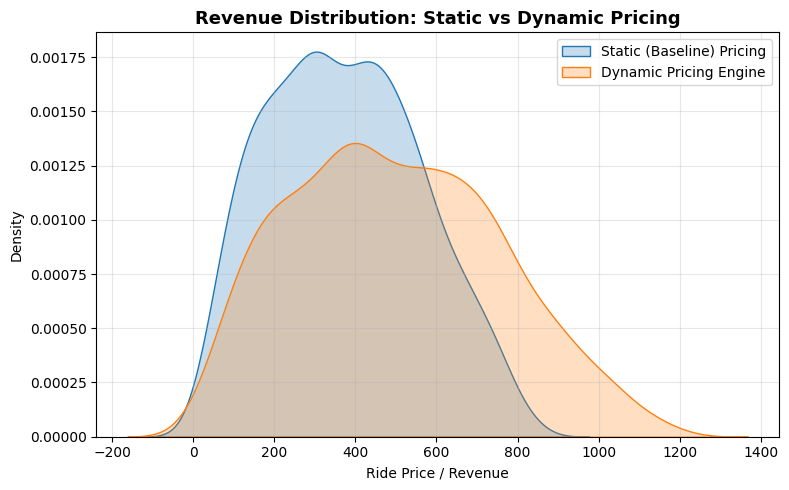

✅ Evaluation results saved as 'pricing_engine_results.csv'


In [5]:
# Dynamic Pricing Engine Evaluation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Step 1: Load dataset

df = pd.read_csv("dynamic_pricing.csv")  # use your actual CSV name

required_cols = ["Historical_Cost_of_Ride", "Number_of_Riders", "Number_of_Drivers", "Time_of_Booking"]
for col in required_cols:
    if col not in df.columns:
        raise KeyError(f"❌ Missing required column: '{col}'")

print(f"✅ Data loaded successfully — {df.shape[0]} rows, {df.shape[1]} columns")

# Step 2: Time-based adjustment

def time_based_adjustment(time):
    if time == "Morning":
        return 1.20   # peak
    elif time == "Evening":
        return 1.15   # semi-peak
    elif time == "Night":
        return 1.10   # moderate
    else:
        return 1.00   # normal/off-peak

df["Time_Adjustment"] = df["Time_of_Booking"].apply(time_based_adjustment)

# Step 3: Inventory-based adjustment

def inventory_based_adjustment(row):
    ratio = row["Number_of_Riders"] / (row["Number_of_Drivers"] + 1e-5)
    if ratio > 1.5:
        return 1.25   # high demand (more riders than drivers)
    elif ratio < 0.8:
        return 0.90   # excess supply (more drivers)
    else:
        return 1.00   # balanced demand-supply

df["Inventory_Adjustment"] = df.apply(inventory_based_adjustment, axis=1)

# Step 4: Dynamic Baseline Pricing

df["Static_Price"] = df["Historical_Cost_of_Ride"]
df["Dynamic_Price"] = df["Historical_Cost_of_Ride"] * df["Time_Adjustment"] * df["Inventory_Adjustment"]


# Step 5: KPI Evaluation

df["Revenue_Lift_Pct"] = ((df["Dynamic_Price"] - df["Static_Price"]) / df["Static_Price"]) * 100

avg_static_rev = df["Static_Price"].mean()
avg_dynamic_rev = df["Dynamic_Price"].mean()
avg_lift = df["Revenue_Lift_Pct"].mean()

print("\n========= 📊 Pricing Engine Evaluation =========")
print(f"💵 Avg Static Revenue: ₹{avg_static_rev:.2f}")
print(f"⚙️ Avg Dynamic Revenue: ₹{avg_dynamic_rev:.2f}")
print(f"📈 Avg Revenue Lift: {avg_lift:.2f}%")
print("===============================================\n")


# Step 6: Visualization

plt.figure(figsize=(8, 5))
sns.kdeplot(df["Static_Price"], label="Static (Baseline) Pricing", fill=True)
sns.kdeplot(df["Dynamic_Price"], label="Dynamic Pricing Engine", fill=True)
plt.title("Revenue Distribution: Static vs Dynamic Pricing", fontsize=13, weight="bold")
plt.xlabel("Ride Price / Revenue")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Step 7: Save output

df.to_csv("pricing_engine_results.csv", index=False)
print("✅ Evaluation results saved as 'pricing_engine_results.csv'")

In [6]:
import pandas as pd

# Load dataset
df = pd.read_csv("dynamic_pricing.csv")
print(f"✅ Dataset Loaded Successfully — {df.shape[0]} rows, {df.shape[1]} columns")

# --- Time-Based Pricing Rule ---
def time_based_adjustment(time):
    if time == "Morning":
        return 1.20
    elif time == "Evening":
        return 1.15
    elif time == "Night":
        return 1.10
    else:
        return 1.00

# --- Inventory-Based Pricing Rule ---
def inventory_based_adjustment(row):
    ratio = row['Number_of_Riders'] / (row['Number_of_Drivers'] + 1e-5)
    if ratio > 1.5:
        return 1.25
    elif ratio < 0.8:
        return 0.90
    else:
        return 1.00

# Apply rules
df['Time_Adjustment'] = df['Time_of_Booking'].apply(time_based_adjustment)
df['Inventory_Adjustment'] = df.apply(inventory_based_adjustment, axis=1)

# Compute Baseline Price
df['Baseline_Price'] = df['Historical_Cost_of_Ride'] * df['Time_Adjustment'] * df['Inventory_Adjustment']

# Display results
print("\n🔹 Sample of Baseline Pricing Adjustments:")
print(df[['Historical_Cost_of_Ride', 'Time_Adjustment', 'Inventory_Adjustment', 'Baseline_Price']].head())

# Calculate and display total revenue
baseline_revenue = df['Baseline_Price'].sum()
print(f"\n💰 Total Baseline Revenue: ₹{baseline_revenue:,.2f}")

✅ Dataset Loaded Successfully — 1000 rows, 10 columns

🔹 Sample of Baseline Pricing Adjustments:
   Historical_Cost_of_Ride  Time_Adjustment  Inventory_Adjustment  \
0               284.257273             1.10                  1.25   
1               173.874753             1.15                  1.00   
2               329.795469             1.00                  1.00   
3               470.201232             1.00                  1.25   
4               579.681422             1.00                  1.25   

   Baseline_Price  
0      390.853750  
1      199.955966  
2      329.795469  
3      587.751540  
4      724.601778  

💰 Total Baseline Revenue: ₹499,359.02
